# Facebook Friend Recommendation

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [17]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [3]:
#Loading feature extracted Data
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [4]:
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [5]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [6]:
train_graph_new=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',nodetype=int)

#### preferential attachment

In [11]:
#function to preferential attachment
# https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_prediction.preferential_attachment.html
def compute_pref_attach(a,b):
    pred= nx.preferential_attachment(train_graph_new,[(a,b)])
    for u, v, p in pred:
        x=p
    return p

In [8]:
#featurizing computr preferential attachment
pref_train=[]
for i,row in df_final_train.iterrows():
    try:
        pref_train.append(compute_pref_attach(row['source_node'],row['destination_node']))
    except:
        pref_train.append(0)
        
pref_test=[]
for i,row in df_final_test.iterrows():
    try:
        pref_test.append(compute_pref_attach(row['source_node'],row['destination_node']))
    except:
        pref_test.append(0)

In [9]:
df_final_train['pref_attach']=pref_train
df_final_test['pref_attach']=pref_test

In [10]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attach
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,144
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,14134
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1920
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,70
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,52


#### dot product of svd features

In [12]:
#adding dot product of svd features
df_final_train['dot_u']=df_final_train.apply(lambda row: np.dot(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]\
                                            ,row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']]),axis=1)
df_final_test['dot_u']=df_final_test.apply(lambda row: np.dot(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']]\
                                            ,row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']]),axis=1)

df_final_train['dot_v']=df_final_train.apply(lambda row: np.dot(row[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]\
                                            ,row[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']]),axis=1)


df_final_test['dot_v']=df_final_test.apply(lambda row: np.dot(row[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]\
                                            ,row[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']]),axis=1)

In [13]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attach,dot_u,dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,144,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,14134,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1920,1.787503e-35,2.467873e-36
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,70,4.710376e-20,3.159386e-18
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,52,7.773952e-14,0.000000e+00


In [14]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [15]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

### XGBOOST Hperparametr tunning

Estimators =  5 Train Score 0.9276333993146456 test Score 0.9268803418803419
Estimators =  10 Train Score 0.9302705761532497 test Score 0.9260226650377049
Estimators =  50 Train Score 0.9723734501252066 test Score 0.9311728916680752
Estimators =  100 Train Score 0.9768251110189465 test Score 0.9293160437325197
Estimators =  250 Train Score 0.9870221257175025 test Score 0.9270780214176441


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

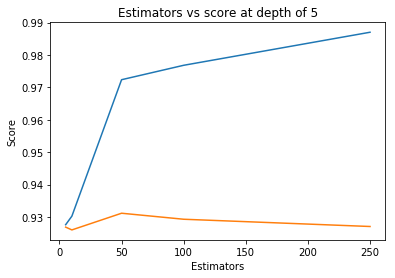

In [18]:
estimators = [5,10,50,100,250]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(bootstrap=True, class_weight=None, 
            max_depth=5, max_features='auto', n_estimators=i,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  10 Train Score 0.9616845783475204 test Score 0.9249289697990108
depth =  25 Train Score 0.9926165855228746 test Score 0.932196251842493
depth =  50 Train Score 0.9986695875721474 test Score 0.9315897910272043
depth =  70 Train Score 0.9986695875721474 test Score 0.9314832334699885
depth =  120 Train Score 0.9986695875721474 test Score 0.9314832334699885
depth =  160 Train Score 0.9986695875721474 test Score 0.9314832334699885
depth =  250 Train Score 0.9986695875721474 test Score 0.9314832334699885


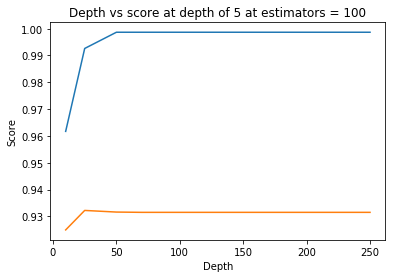

In [32]:
depths = [10,25,50,70,120,160,250]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None,
            max_depth=i, n_estimators=121, random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 100')
plt.show()

<strong> The above model is sligtly overfitting because there is difference between train score and test score </strong>

In [29]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [30]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [31]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9659171549644168
Test f1 score 0.9272501525705508


In [20]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"n_estimators":[50,100,150,200],"max_depth": [10,20,30]}

clf = xgb.XGBClassifier(random_state=25,n_jobs=-1)

xg = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=3,cv=5,scoring='f1',random_state=25,verbose=5,n_jobs=-1)

xg.fit(df_final_train,y_train)
print('mean test scores',xg.cv_results_['mean_test_score'])
print('mean train scores',xg.cv_results_['mean_train_score'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 24.2min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 26.9min finished


mean test scores [0.97886216 0.97977876 0.98185766]
mean train scores [1.         0.99270274 0.999995  ]


In [21]:
print(xg.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=25, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


In [22]:
clf = xgb.XGBClassifier(random_state=25,n_jobs=-1,n_estimator=200,depth=10)

In [23]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [24]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.973270694961931
Test f1 score 0.928536642175027


Train confusion_matrix


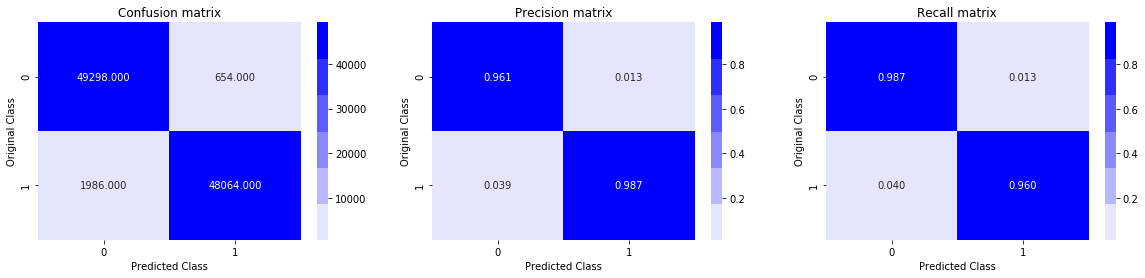

Test confusion_matrix


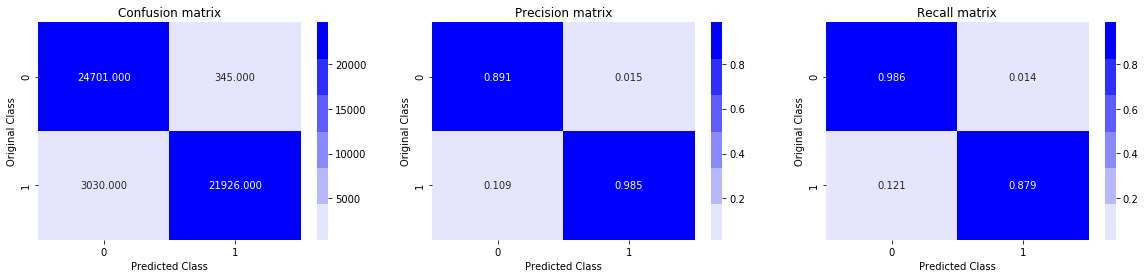

In [25]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

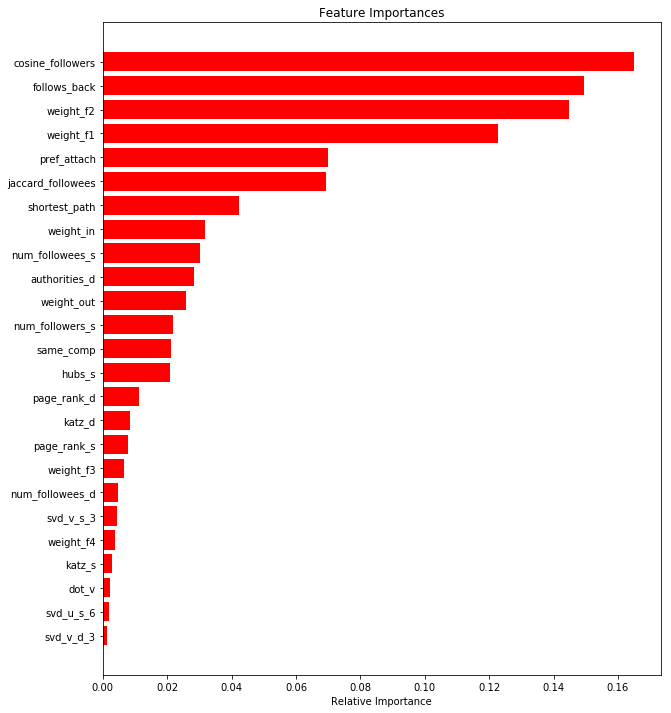

In [26]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Steps :

    - Using EDA we got 1862220 users and 9437519 edges 
    - Using EDA we get to know about number of follwers and followees and thier behavious
    - We got weakly connected componenets and divided data into Train and test (CV)
    - For Featurization we  added new featues in 
        Similarity measures
        -- Jaccard Distance => | X intersection Y | / | X union Y |
        -- Cosine distance => | X intersection Y | / | X dot Y |
        Ranking Measures
        -- Page Ranking
        Other Graph Features
        -- Shortest path
        -- Checking for same community
        -- Adamic/Adar Index => 1 / log(N(u))
        -- Is persion was following back
        -- Katz Centrality
        -- Hits Score
        Weight Features => 1/ sqrt(1 + |x|)
        SVD features for both source and destination
        Preferential Attachment 
        SVD feature => dot product of source and destination nodes
    - XGBoost and RandomForest as classification Model

## Conclusion

<b> - The Most Important featurres are cosine follwers, Follows back, weight features, Preferential Attachment

In [33]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','121','25','0.96','0.91'])
x.add_row(['XGBOOST','200','10','0.97','0.92'])
print(x)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     121      |     25    |      0.96      |      0.91     |
|    XGBOOST    |     200      |     10    |      0.97      |      0.92     |
+---------------+--------------+-----------+----------------+---------------+
